### Test 1 - Audio Classification from Seth Adams in YT

!![![Foo](https://www.nicepng.com/png/full/891-8915842_youtube-logo-free-png-small-youtube-logo-png.png)](https://www.youtube.com/playlist?list=PLhA3b2k8R3t2Ng1WW_7MiXeh1pfQJQi_P)



In [9]:
from eda import plot_signals, plot_fft, plot_fbank, plot_mfccs

In [10]:
import os
from tqdm import tqdm
# import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank

In [11]:
# dictionnaires vides pour stocker les infos des signaux qui seront mis en forme par le logiciel 
signals = {}
fft = {}
fbank = {}
mfccs = {}

# document qui donne les classes associées aux noms des fichiers
data = pd.read_csv("instruments.csv")

# liste des catégories d'instruments disponibles 
classes = list(data.label.unique())

In [12]:
## Noise threshold detection - Seuillage du signal sur detection de bruit 
# cela dépend des caractéritiques de chaque microphone 

# calculer une estimation de l'enveloppe du signal et si son intensité diminue trop en moyenne,
# tuer le signal au temps correspondant par l'utilisation d'un masque booléen.
# L'enveloppe est calculée comme étant une moyenne locale du signal.
# le signal après application de l'enveloppe est considéré "cleaned"

def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10), min_periods=1, center=True).mean()
    # rolling windows over data (simplest way)
    # mean periods : min nb of point in windows to create calculations 
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [13]:
## calc_fft function 
# will compute the Fast Fourier Transform of each signal 
# y : signal, rate : rate of sampling 
# freq : frequencies computed by FFT, Y :  magnitude of the frequencies

def calc_fft(y, rate):
    n=len(y)
    freq=np.fft.rfftfreq(n,d=1/rate) # d space between each sample, amount of time between each sample 
    # array, Return the Discrete Fourier Transform sample frequencies; d, Sample spacing (inverse of the sampling rate)
    Y=abs(np.fft.rfft(y))
    return(Y, freq)

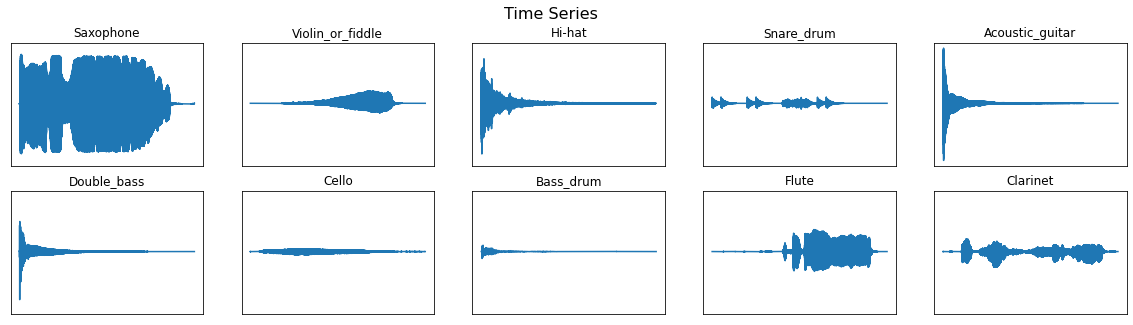

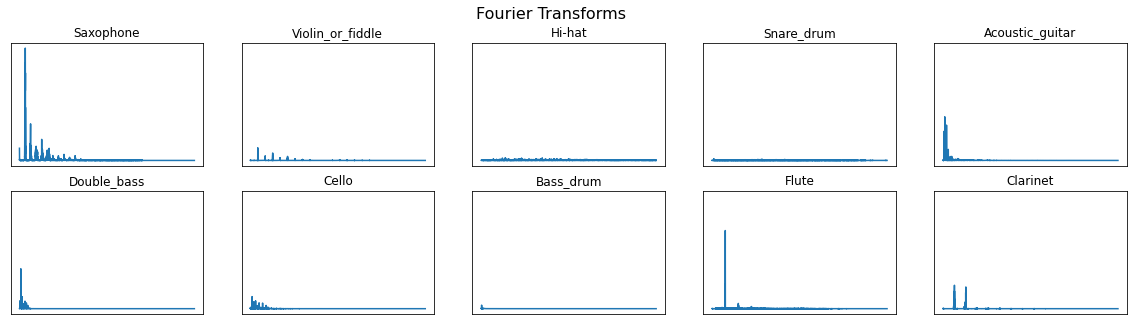

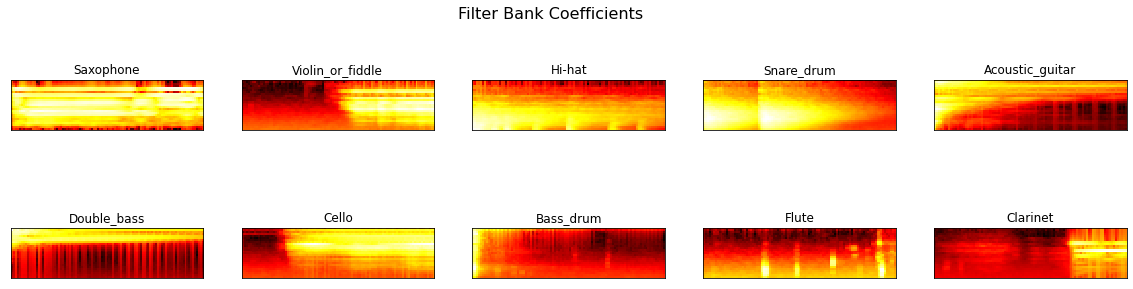

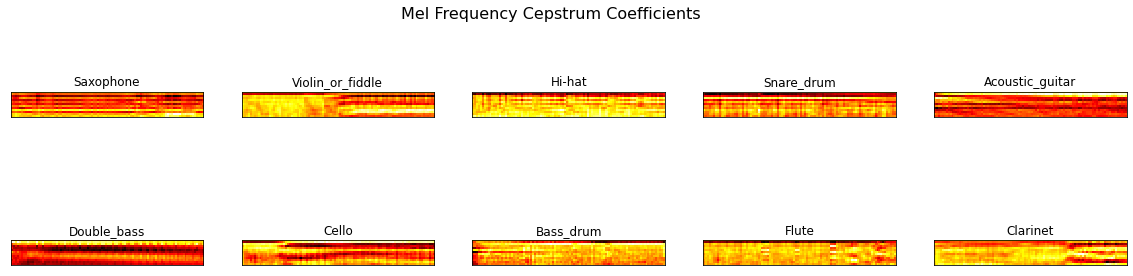

In [14]:
# prend un signal de chaque classe pour le tracé 
# calcule l'enveloppe  et applique l'enveloppe
# calcule la fft pour chaque signal 
for c in classes:
    wav_file = data[data.label == c ].iloc[0,0]
    rate, signal = wavfile.read('wavfiles/'+wav_file)
    
    mask = envelope(signal, rate, 0.0005)  
    signal = signal[mask]
    
    signals[c]=signal
    fft[c] = calc_fft(signal,rate)
    
    bank=logfbank(signal[:rate], rate, nfilt=26, nfft=1103).T
    fbank[c]=bank
    # signal[:rate] get only 1 sec of signal 
    # nfft=1103 relatif aux nombres de fenêtres différentes que la fft peut faire sur tout le signal
    # à ce moment on a un spectrogram
    # seulement pour stocker le bank en mémoire 
        
    mel=mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1103).T
    mfccs[c]= mel
    # numcep number of ceptrum we keep after Direct Cosin Transform
    # réalise toutes les opération depuis la FFT : calcule les filter banks, applique l'échelle log puis calcule les mfcc 
    
plot_signals(signals)    
plt.show()

plot_fft(fft)
plt.show()

plot_fbank(fbank)
plt.show()

plot_mfccs(mfccs)
plt.show()

In [15]:
# down sample the audio : most info is contained at low frequencies (until 8000 Hz)
if len(os.listdir('clean')) == 0:
    for f in tqdm(data.fname):
        rate, signal = wavfile.read('wavfiles/'+f)
        mask = envelope(signal, rate, 0.0005)
        wavfile.write(filename='clean/'+f, rate=rate, data=signal[mask])

In [16]:
fft['Saxophone']

(array([2.33282780e+07, 2.07962589e+07, 6.82013624e+06, ...,
        1.94977282e+02, 3.06844878e+02, 2.20000000e+02]),
 array([0.00000000e+00, 2.41545894e-01, 4.83091787e-01, ...,
        2.20495169e+04, 2.20497585e+04, 2.20500000e+04]))

In [17]:
bank.shape

(26, 99)